# Classification: Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model (which is based on the network architecture of Krizhevsky et al. for ImageNet).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import os

%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize']      = (10, 10)  # large images
plt.rcParams['image.interpolation'] = 'nearest' # don't interpolate: show square pixels
plt.rcParams['image.cmap']          = 'gray'    # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
import sys
caffe_root = '../caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:
model_id = 'bvlc_reference_caffenet' # A variant of alexnet
#model_id = 'bvlc_googlenet' # TODO
#model_id = 'bvlc_alexnet'

model_def     = '%(caffe_root)s/models/%(model_id)s/deploy.prototxt'         % locals()
model_weights = '%(caffe_root)s/models/%(model_id)s/%(model_id)s.caffemodel' % locals()

if os.path.isfile(model_weights):
    print 'Found model[%(model_id)s]' % locals()
else:
    print 'Downloading model[%(model_id)s]...' % locals()
    !../scripts/download_model_binary.py ../models/{model_id}

Found model[bvlc_reference_caffenet]


In [4]:
caffe.set_mode_cpu()

net = caffe.Net(
    model_def,      # defines the structure of the model
    model_weights,  # contains the trained weights
    caffe.TEST,     # use test mode (e.g., don't perform dropout)
)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


- Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

- Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [6]:
def vis_square(data):
    '''
    Take an array of shape (n, height, width) or (n, height, width, 3)
    and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
    '''
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (
        ((0, n ** 2 - data.shape[0]), (0, 1), (0, 1)) # add some space between filters
        + ((0, 0),)
        * (data.ndim - 3) # don't pad the last dimension (if there is one)
    )
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)
    plt.axis('off')
    plt.show() # So we can have multiple plt.imshow's from the same cell

In [7]:
# set the size of the input (we can skip this if we're happy
# with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(
    50,        # batch size
    3,         # 3-channel (BGR) images
    227, 227,  # image size is 227x227
    #224, 224,  # image size is 227x227 [TODO Make googlenet work]
)

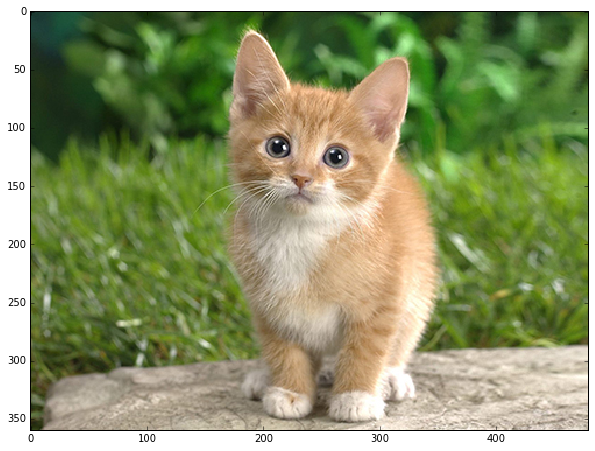

In [8]:
# Pick your image
image_path = caffe_root + 'examples/images/cat.jpg'
#image_path = 'spectrograms/PC1_20090705_070000_0040.bmp'

image = caffe.io.load_image(image_path)
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [9]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

# perform classification (slow, ~secs)
output = net.forward()

output_prob = output['prob'][0] # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 281


The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels..."

In [10]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'probabilities and labels:'
top_inds = output_prob.argsort()[::-1][:20] # top k predictions from softmax output
pprint(zip(output_prob[top_inds], labels[top_inds]))

probabilities and labels:
[(0.31243625, 'n02123045 tabby, tabby cat'),
 (0.23797135, 'n02123159 tiger cat'),
 (0.12387258, 'n02124075 Egyptian cat'),
 (0.10075716, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957333, 'n02127052 lynx, catamount'),
 (0.05399761, 'n02119789 kit fox, Vulpes macrotis'),
 (0.014484304, 'n02123394 Persian cat'),
 (0.011321871, 'n04493381 tub, vat'),
 (0.0063290037, 'n02120505 grey fox, gray fox, Urocyon cinereoargenteus'),
 (0.0061893421, 'n02112018 Pomeranian'),
 (0.0050757681, 'n04589890 window screen'),
 (0.0047016749, 'n02909870 bucket, pail'),
 (0.0044144648, 'n02115913 dhole, Cuon alpinus'),
 (0.0038899749, 'n02325366 wood rabbit, cottontail, cottontail rabbit'),
 (0.0036219293, 'n04070727 refrigerator, icebox'),
 (0.003299481, 'n02342885 hamster'),
 (0.0032250041, 'n04447861 toilet seat'),
 (0.0029704943, 'n02328150 Angora, Angora rabbit'),
 (0.0023334052, 'n02123597 Siamese cat, Siamese'),
 (0.0021963168, 'n02326432 hare')]


### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [11]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    params = net.params.get(layer_name, [])
    print '%-52s %-20s %s' % (layer_name, blob.data.shape, [x.data.shape for x in params])

data                                                 (50, 3, 227, 227)    []
conv1                                                (50, 96, 55, 55)     [(96, 3, 11, 11), (96,)]
pool1                                                (50, 96, 27, 27)     []
norm1                                                (50, 96, 27, 27)     []
conv2                                                (50, 256, 27, 27)    [(256, 48, 5, 5), (256,)]
pool2                                                (50, 256, 13, 13)    []
norm2                                                (50, 256, 13, 13)    []
conv3                                                (50, 384, 13, 13)    [(384, 256, 3, 3), (384,)]
conv4                                                (50, 384, 13, 13)    [(384, 192, 3, 3), (384,)]
conv5                                                (50, 256, 13, 13)    [(256, 192, 3, 3), (256,)]
pool5                                                (50, 256, 6, 6)      []
fc6                                 

layer[conv1], shape[(96, 3, 11, 11)]


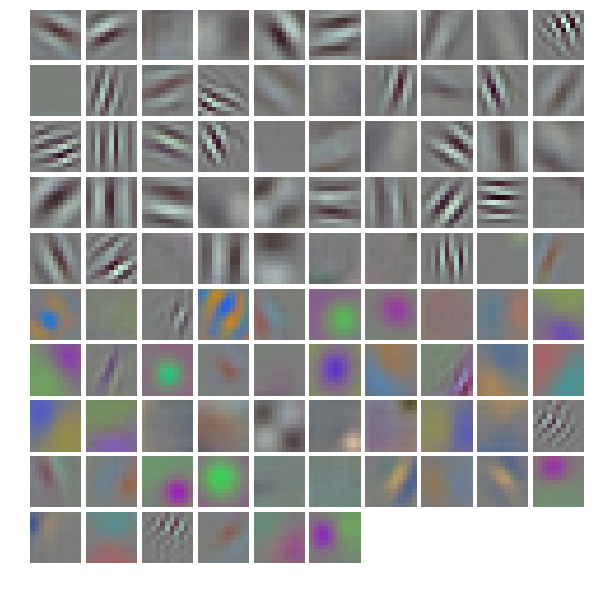

layer[conv1], shape[(96,)]
    Error: axes don't match array
layer[conv2], shape[(256, 48, 5, 5)]
    Error: Invalid dimensions for image data
layer[conv2], shape[(256,)]
    Error: axes don't match array
layer[conv3], shape[(384, 256, 3, 3)]
    Error: Invalid dimensions for image data
layer[conv3], shape[(384,)]
    Error: axes don't match array
layer[conv4], shape[(384, 192, 3, 3)]
    Error: Invalid dimensions for image data
layer[conv4], shape[(384,)]
    Error: axes don't match array
layer[conv5], shape[(256, 192, 3, 3)]
    Error: Invalid dimensions for image data
layer[conv5], shape[(256,)]
    Error: axes don't match array
layer[fc6], shape[(4096, 9216)]
    Error: axes don't match array
layer[fc6], shape[(4096,)]
    Error: axes don't match array
layer[fc7], shape[(4096, 4096)]
    Error: axes don't match array
layer[fc7], shape[(4096,)]
    Error: axes don't match array
layer[fc8], shape[(1000, 4096)]
    Error: axes don't match array
layer[fc8], shape[(1000,)]
    Error: ax

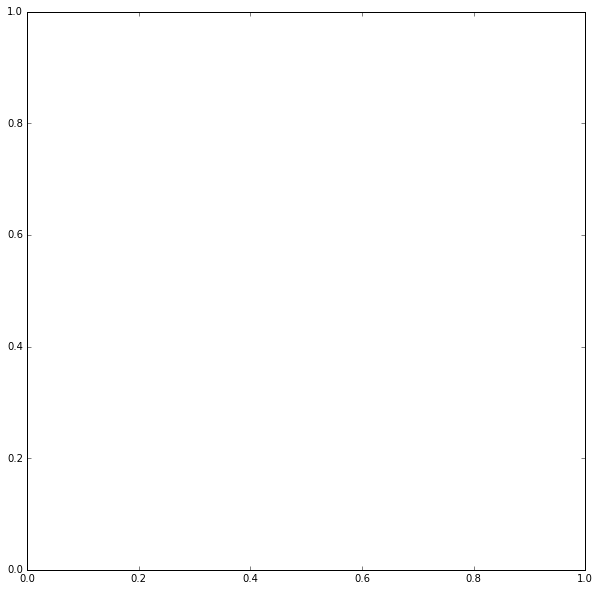

In [12]:
# the parameters are a list of [weights, biases]
#filters = net.params['conv1'][0].data
#vis_square(filters.transpose(0, 2, 3, 1))

# TODO
for layer_name, params in net.params.iteritems():
    for param in params:
        print 'layer[%s], shape[%s]' % (layer_name, param.data.shape)
        try:
            vis_square(param.data.transpose(0, 2, 3, 1))
        except Exception, e:
            print '    Error:', e

layer[data], shape[(50, 3, 227, 227)]


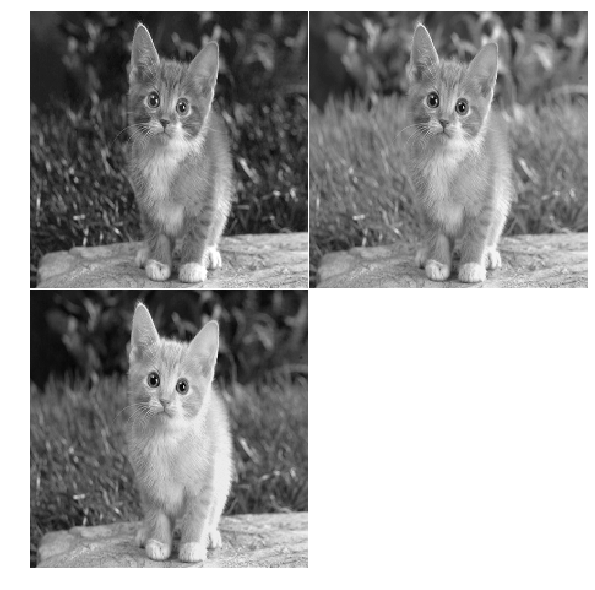

layer[conv1], shape[(50, 96, 55, 55)]


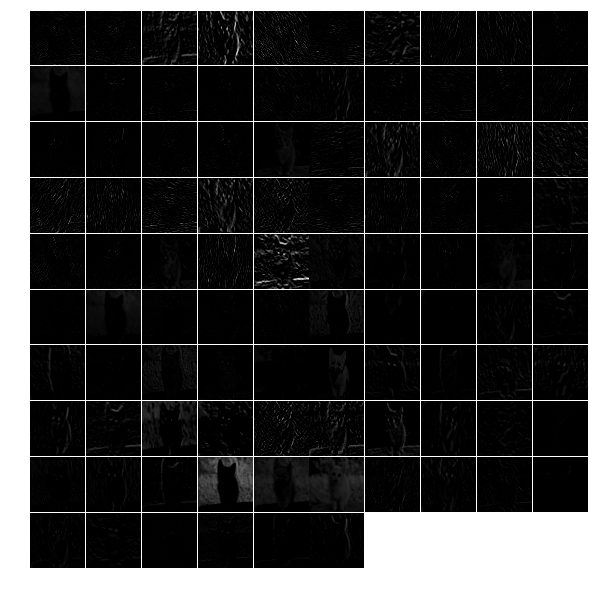

layer[pool1], shape[(50, 96, 27, 27)]


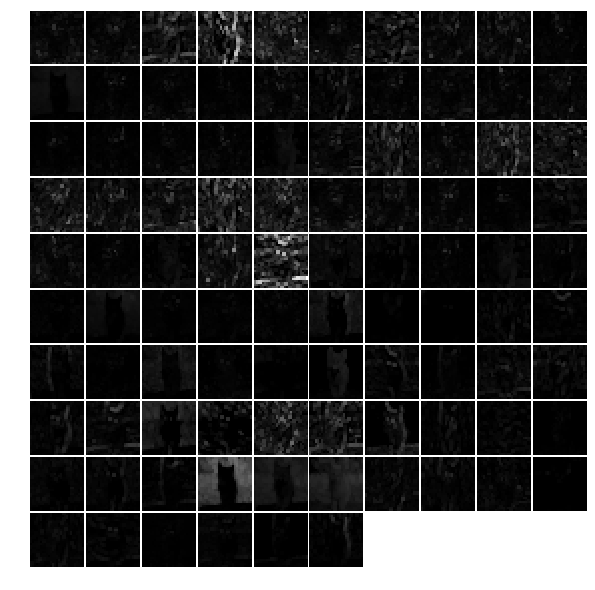

layer[norm1], shape[(50, 96, 27, 27)]


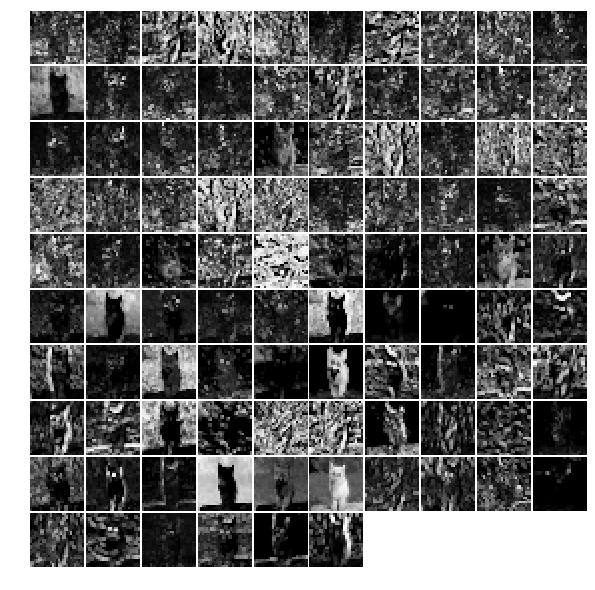

layer[conv2], shape[(50, 256, 27, 27)]


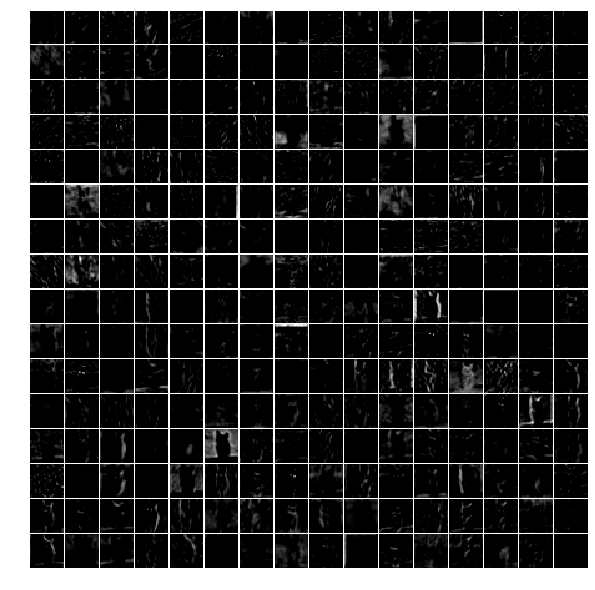

layer[pool2], shape[(50, 256, 13, 13)]


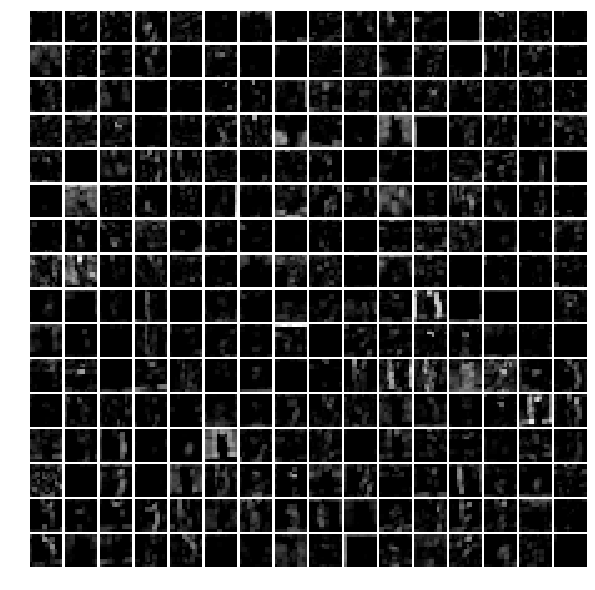

layer[norm2], shape[(50, 256, 13, 13)]


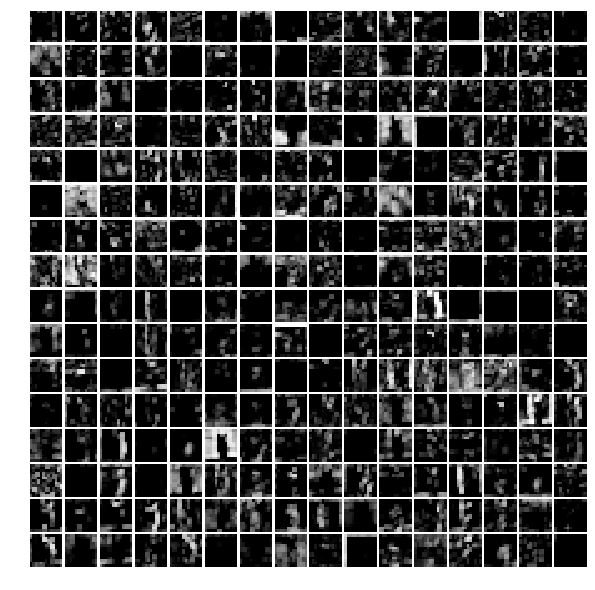

layer[conv3], shape[(50, 384, 13, 13)]


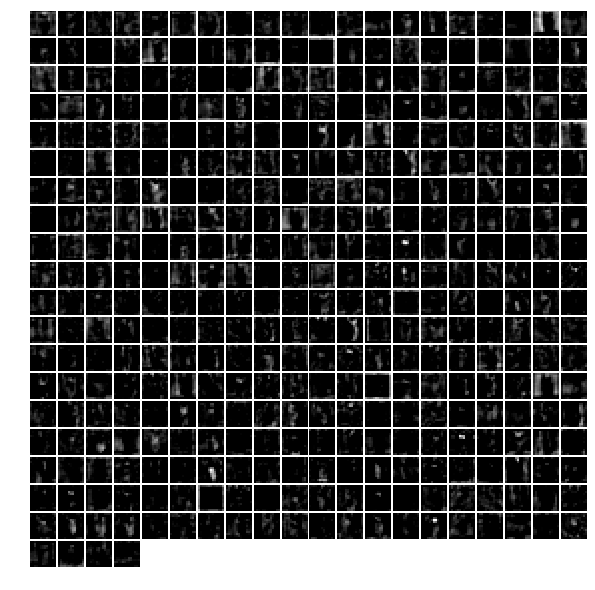

layer[conv4], shape[(50, 384, 13, 13)]


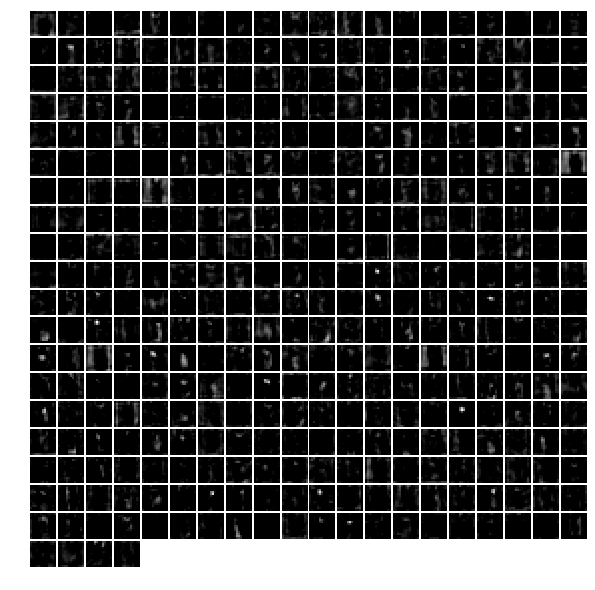

layer[conv5], shape[(50, 256, 13, 13)]


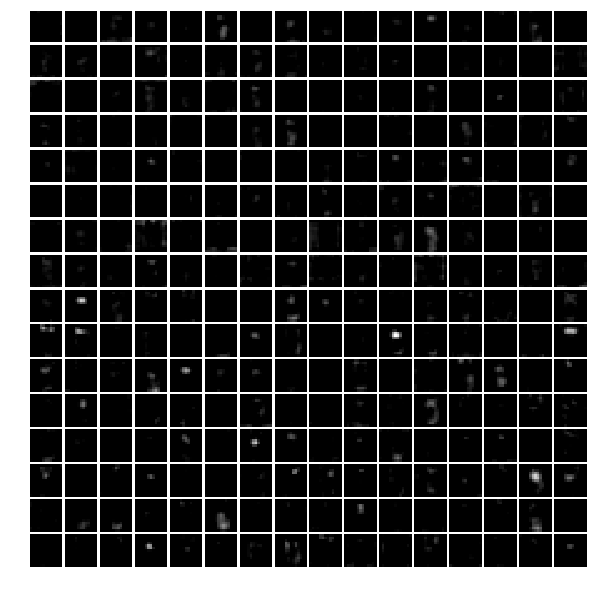

layer[pool5], shape[(50, 256, 6, 6)]


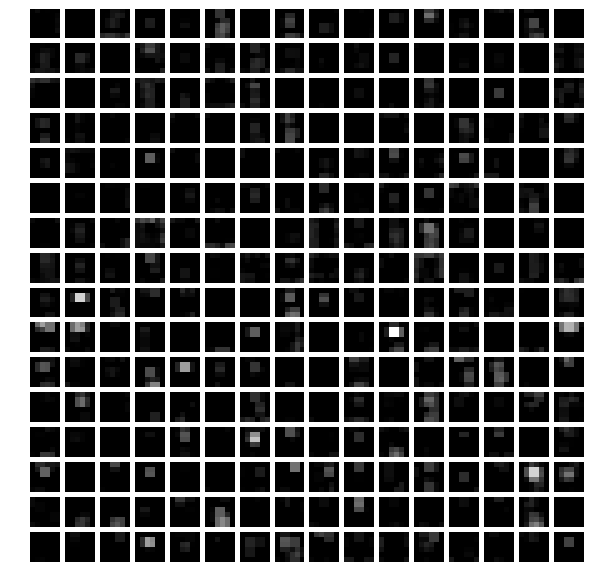

layer[fc6], shape[(50, 4096)]
    Error: Unable to create correctly shaped tuple from ((0, 0), (0, 1), (0, 1))
layer[fc7], shape[(50, 4096)]
    Error: Unable to create correctly shaped tuple from ((0, 0), (0, 1), (0, 1))
layer[fc8], shape[(50, 1000)]
    Error: Unable to create correctly shaped tuple from ((0, 24), (0, 1), (0, 1))
layer[prob], shape[(50, 1000)]
    Error: Unable to create correctly shaped tuple from ((0, 24), (0, 1), (0, 1))


In [13]:
for layer_name, blob in net.blobs.iteritems():
    print 'layer[%s], shape[%s]' % (layer_name, blob.data.shape)
    try:
        vis_square(blob.data[0])
    except Exception, e:
        print '    Error:', e

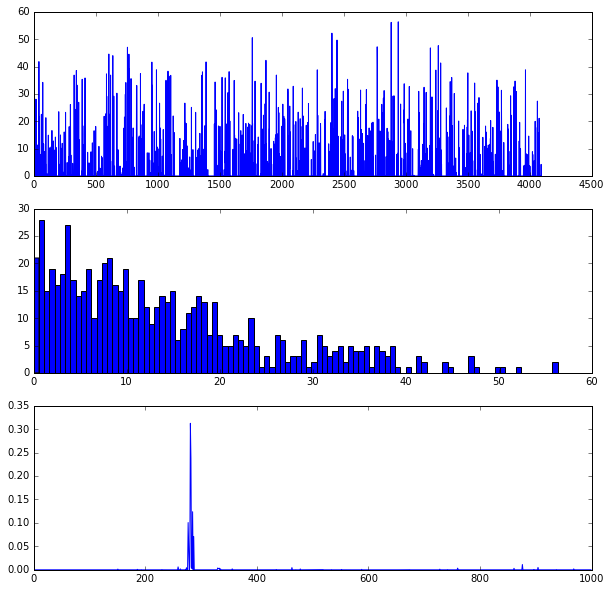

In [14]:
# The first fully connected layer, `fc6` (rectified)
# - We show the output values and the histogram of the positive values
plt.subplot(3, 1, 1); plt.plot(net.blobs['fc6'].data[0].flat)
plt.subplot(3, 1, 2); plt.hist(net.blobs['fc6'].data[0].flat[net.blobs['fc6'].data[0].flat > 0], bins=100)

# The final probability output, `prob`
# - Note the cluster of strong predictions; the labels are sorted semantically
# - The top peaks correspond to the top predicted labels, as shown above
plt.subplot(3, 1, 3); plt.plot(net.blobs['prob'].data[0].flat)

None